# Unit 9: Discrete Fourier Transform (DFT)

<ul> 
    <li><a href='#learn'>Overview and Learning Objectives</a></li>    
    <li><a href='#inner'>Inner Product</a></li>
    <li><a href='#dft'>Definition of DFT</a></li>
    <li><a href='#phase'>DFT Phase</a></li>
    <li><a href='#dftmatrix'>DFT Matrix</a></li>
    <li><a href='#fft'>Fast Fourier Transform (FFT)</a></li>
    <li><a href='#exercise_freq_index'>Exercise 1: Interpretation of Frequency Indices</a></li>
    <li><a href='#exercise_missing_time'>Exercise 2: Missing Time Localization</a></li>    
    <li><a href='#exercise_chirp'>Exercise 3: Chirp Signal</a></li>   
    <li><a href='#exercise_inverse'>Exercise 4: Inverse DFT</a></li>    
</ul>

<a id='learn'></a> 
<div class="alert alert-block alert-warning">
<h2>Overview and Learning Objectives</h2>

    
The <strong>Fourier transform</strong> is one of the most important tools for a wide range of engineering and computer science applications. The general idea of <strong>Fourier analysis</strong> is to decompose a given signal into a weighted superposition of sinusoidal functions. Since these functions possess an explicit physical meaning regarding their frequencies, the decomposition is typically more accessible for subsequent processing steps than the original signal. Assuming that you are familiar with the Fourier transform and its applications in signal processing, we review in this unit the discrete variant of the Fourier transform known as <strong>Discrete Fourier Transform</strong> (DFT). We define the inner product that allows for comparing two vectors (e.g., discrete-time signals of finite length). The DFT can be thought of as comparing a given signal of finite length with a specific set of exponential signals (a complex variant of sinusoidal signals), each comparison yielding a complex-valued Fourier coefficient. Then, using suitable visualizations, we show how you can interpret the amplitudes and phases of these coefficients. Recall that one can express the DFT as a complex-valued square matrix. We show how separately plotting the real and imaginary parts leads to beautiful and insightful images. Applying a DFT boils down to computing a matrix&ndash;vector product, which we implement via the standard NumPy function <code>np.dot</code>. Since the number of operations for computing a DFT via a simple matrix&ndash;vector product is quadratic in the input length, the runtime of this approach becomes problematic with increasing length. This issue is exactly where the fast Fourier transform (FFT) comes into the game. We present this famous divide-and-conquer algorithm and provide a Python implementation. Furthermore, we compare the runtime behavior between the FFT implementation and the naive DFT implementation. We will further deepen your understanding of the Fourier transform by considering further examples and visualization in the exercises. In <a href='#exercise_freq_index'>Exercise 1</a>, you will learn how to interpret and plot frequency indices in a physically meaningful way. In <a href='#exercise_missing_time'>Exercise 2</a>, we discuss the issue of loosing time information when applying the Fourier transform, which is the main motivation for the <a href='https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html'>short-time Fourier transform</a>. In <a href='#exercise_chirp'>Exercise 3</a>, you will apply the DFT to a <strong>chirp signal</strong>, which yields another illustrative example of the DFT's properties. Finally, in <a href='#exercise_inverse'>Exercise 4</a>, we will invite you to explore the relationship between the DFT and its inverse. Again, an overarching goal of this unit is to apply and deepen your Python programming skills within the context of a central topic for signal processing. 
    
</div>

<a id='inner'></a> 
## Inner Product

In this notebook, we consider [discrete-time (DT) signals](PCP_08_signal.html) of finite length $N\in\mathbb{N}$, which we represent as vector 

$$
x=(x(0),x(1),...,x(N-1))^\top\in\mathbb{R}^N
$$ 

with samples $x(n)\in\mathbb{R}^N$ for $n\in[0:N-1]$. Note that $\top$ indicates the transpose of a vector, thus converting a row vector into a column vector. Furthermore, note that we start indexing with the index $0$ (thus adapting our mathematical notation to Python conventions). A general concept for comparing two vectors (or signals) is the **inner product**. Given two vectors $x, y \in \mathbb{R}^N$, the inner product between $x$ and $y$ is defined as follows:

$$ 
\langle x | y \rangle := \sum_{n=0}^{N-1} x(n) y(n).
$$

The absolute value of the inner product may be interpreted as a measure of similarity between $x$ and $y$. If $x$ and $y$  are similar (i.e., if they point to more or less the same direction), the inner product $|\langle x | y \rangle|$ is large. If $x$ and $y$ are dissimilar (i.e., if $x$ and $y$ are more or less orthogonal to each other), the inner product $|\langle x | y \rangle|$ is close to zero.

One can extend this concept to **complex-valued** vectors $x,y\in\mathrm{C}^N$, where the inner product is defined as 

$$
\langle x | y \rangle := \sum_{n=0}^{N-1} x(n) \overline{y(n)}.
$$

In the case of real-valued signals, the complex conjugate does not play any role and the definition of the complex-valued inner product reduces to the real-valued one. In the following code cell, we give some examples.

<div class="alert alert-block alert-warning">
<strong>Note:</strong>
One can use the NumPy function <code>np.vdot</code> to compute the inner product. However, opposed to the mathematical convention that conjugates the second argument, this function applies complex conjugation on the first argument. Therefore, for computing $\langle x | y \rangle$ as defined above, one has to call <code>np.vdot(y, x)</code>.
</div>

In the following, we generate and visualize three signals $x_1$, $x_2$, $x_3$. Then, we compute and discuss different inner products using the signals.

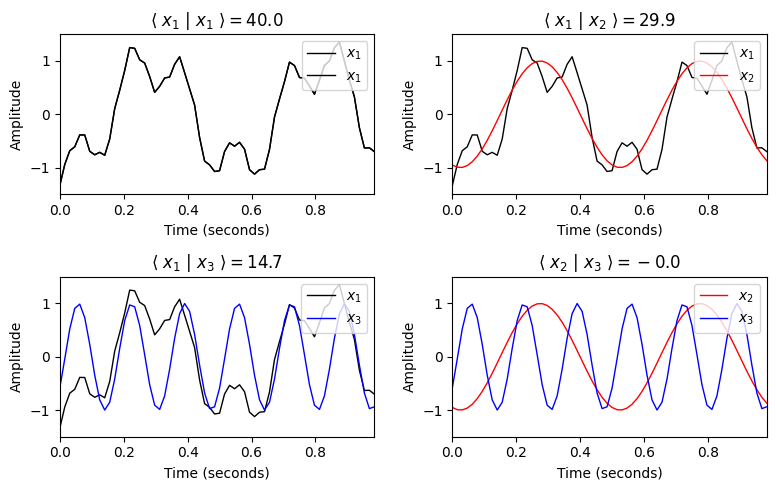

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from FAU_PCP import signal
%matplotlib inline

Fs = 64
dur = 1
x1, t = signal.generate_example_signal(Fs=Fs, dur=dur)
x2, t = signal.generate_sinusoid(dur=dur, Fs=Fs, amp=1, freq=2, phase=0.3)
x3, t = signal.generate_sinusoid(dur=dur, Fs=Fs, amp=1, freq=6, phase=0.1)

def plot_inner_product(ax, t, x, y, color_x='k', color_y='r', label_x='x', label_y='y'):
    """Plot inner product

    Notebook: PCP_09_dft.ipynb

    Args:
        ax: Axis handle
        t: Time axis
        x: Signal x
        y: Signal y
        color_x: Color of signal x (Default value = 'k')
        color_y: Color of signal y (Default value = 'r')
        label_x: Label of signal x (Default value = 'x')
        label_y: Label of signal y (Default value = 'y')
    """
    ax.plot(t, x, color=color_x, linewidth=1.0, linestyle='-', label=label_x)
    ax.plot(t, y, color=color_y, linewidth=1.0, linestyle='-', label=label_y)
    ax.set_xlim([0, t[-1]])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    sim = np.vdot(y, x)
    ax.set_title(r'$\langle$ %s $|$ %s $\rangle = %.1f$' % (label_x, label_y, sim))
    ax.legend(loc='upper right')

plt.figure(figsize=(8, 5))
ax = plt.subplot(2, 2, 1)
plot_inner_product(ax, t, x1, x1, color_x='k', color_y='k', label_x='$x_1$', label_y='$x_1$')
ax = plt.subplot(2, 2, 2)
plot_inner_product(ax, t, x1, x2, color_x='k', color_y='r', label_x='$x_1$', label_y='$x_2$')
ax = plt.subplot(2, 2, 3)
plot_inner_product(ax, t, x1, x3, color_x='k', color_y='b', label_x='$x_1$', label_y='$x_3$')
ax = plt.subplot(2, 2, 4)
plot_inner_product(ax, t, x2, x3, color_x='r', color_y='b', label_x='$x_2$', label_y='$x_3$')
plt.tight_layout()

In the above example, one can make the following observations:

* The signal $x_1$ is similar to itself, leading to a large value of $\langle x_1 | x_1 \rangle=40.0$.
* The overall course of the signal $x_1$ strongly correlates with the sinusoid $x_2$, which is reflected by a relatively large value of $\langle x_1 | x_2 \rangle=29.9$.
* There are some finer oscillations of $x_1$ that are captured by $x_3$, leading to a still noticeable value of  $\langle x_1 | x_3 \rangle=14.7$. 
* The two sinusoids $x_2$ and $x_3$ are more or less uncorrelated, which is revealed by the value of $\langle x_2 | x_3 \rangle\approx 0$. 

In other words, the above comparison reveals that the signal $x_1$ has a strong signal component of $2~\mathrm {Hz}$ (frequency of $x_2$) and $6~\mathrm {Hz}$ (frequency of $x_3$). Measuring correlations between an arbitrary signal and sinusoids of different frequencies is exactly the idea of performing a Fourier (or spectral) analysis. 

<a id='dft'></a> 
## Definition of DFT

Let $x\in \mathbb{C}^N$ be a vector of length $N\in\mathbb{N}$. The **discrete Fourier transform** (DFT) of $x$ is defined by:

$$ X(k) := \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N) $$

for $k \in [0:N-1]$. The vector $X\in\mathbb{C}^N$ can be interpreted as a frequency representation of the time-domain signal $x$.   To obtain a geometric interpretation of the DFT, we define the vector $\mathbf{e}_k \in\mathbb{C}^N$ with real part $\mathbf{c}_k=\mathrm{Re}(\mathbf{e}_k)$ and imaginary part $\mathbf{s}_k=\mathrm{Im}(\mathbf{e}_k)$ by

$$\mathbf{e}_k(n) :=  \exp(2 \pi i k n / N) = \cos(2 \pi k n / N) + i \sin(2 \pi k n / N)
= \mathbf{c}_k(n) + i \mathbf{s}_k(n)$$

for each $k \in [0:N-1]$.


This vector can be regarded as a [sampled version](PCP_08_signal.html) of the [exponential function](PCP_07_exp.html) of frequency $k/N$. Using inner products, the DFT can be expressed as

$$ X(k) = \sum_{n=0}^{N-1} x(n) \overline{\mathbf{e}_k}(n) = \langle x | \mathbf{e}_k \rangle,$$

thus measuring the similarity between the signal $x$ and the sampled exponential functions $\mathbf{e}_k$. The absolute value $|X(k)|$ indicates the degree of similarity between the signal $x$ and $\mathbf{e}_k$. In the case that $x\in \mathbb{R}^N$ is a real-valued vector (which is typically the case for audio signals), we obtain:

$$ 
X(k) = \langle x |\mathrm{Re}(\mathbf{e}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{e}_k) \rangle
= \langle x |\mathbf{c}_k \rangle - i\langle x | \mathbf{s}_k \rangle
$$

The following plot shows an example signal $x$ compared with functions $\overline{\mathbf{e}_k}$ for various frequency parameters $k$. The real and imaginary part of $\overline{\mathbf{e}_k}$ are shown in <font color='red'> red</font> and <font color='blue'> blue</font>, respectively.

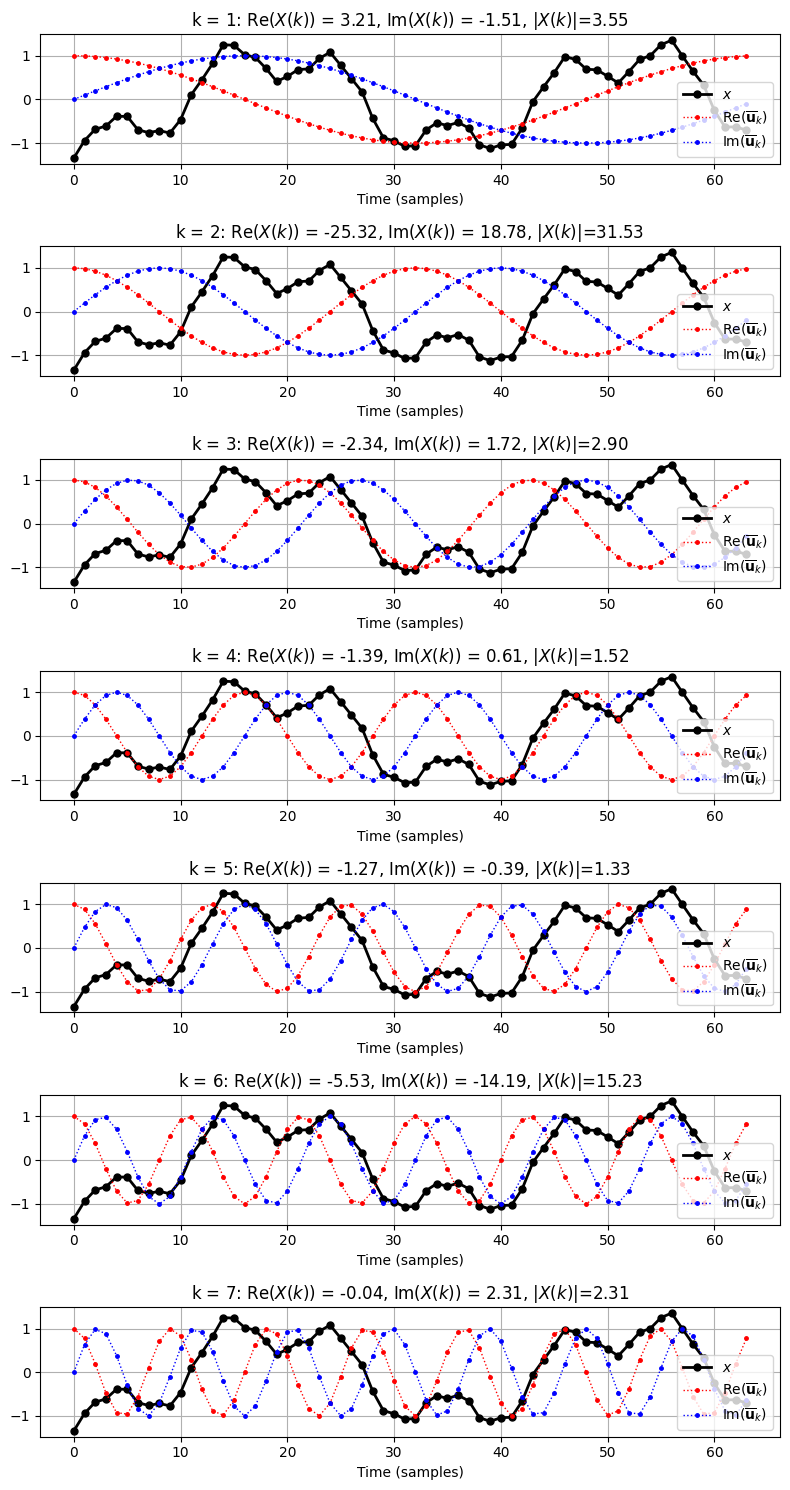

In [5]:
def plot_signal_e_k(ax, x, k, show_e=True, show_opt=False):
    """Plot signal and k-th DFT sinusoid

    Notebook: PCP_09_dft.ipynb

    Args:
        ax: Axis handle
        x: Signal
        k: Index of DFT
        show_e: Shows cosine and sine (Default value = True)
        show_opt: Shows cosine with optimal phase (Default value = False)
    """
    N = len(x)
    time_index = np.arange(N)
    ax.plot(time_index, x, 'k', marker='.', markersize='10', linewidth=2.0, label='$x$')
    plt.xlabel('Time (samples)')
    e_k = np.exp(2 * np.pi * 1j * k * time_index / N)
    x_k = np.real(e_k)
    s_k = np.imag(e_k)
    X_k = np.vdot(e_k, x)

    plt.title(r'k = %d: Re($X(k)$) = %0.2f, Im($X(k)$) = %0.2f, $|X(k)|$=%0.2f' %
              (k, X_k.real, X_k.imag, np.abs(X_k)))
    if show_e is True:
        ax.plot(time_index, x_k, 'r', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$')
        ax.plot(time_index, s_k, 'b', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$')
    if show_opt is True:
        phase_k = - np.angle(X_k) / (2 * np.pi)
        cos_k_opt = np.cos(2 * np.pi * (k * time_index / N - phase_k))
        # d_k = np.sum(x * cos_k_opt)
        ax.plot(time_index, cos_k_opt, 'g', marker='.', markersize='5',
                 linewidth=1.0, linestyle=':', label='$\cos_{k, opt}$')
    plt.grid()
    plt.legend(loc='lower right')


N = 64
x, t = signal.generate_example_signal(Fs=N, dur=1)

plt.figure(figsize=(8, 15))
for k in range(1, 8):
    ax = plt.subplot(7, 1, k)
    plot_signal_e_k(ax, x, k=k)

plt.tight_layout()

<a id='phase'></a>
## DFT Phase

At first sight, the DFT may be a bit confusing: Why is a real-valued signal $x$ compared with a complex-valued sinusoid $\mathbf{e}_k$? What does the resulting complex-valued Fourier coefficient

$$
x_k:= X(k) := \langle x |\mathrm{Re}(\mathbf{e}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{e}_k) \rangle. 
$$

encode? To understand this, we represent the complex number $x_k$ in form of its [polar representation](PCP_06_complex.html#polar)

$$
x_k = |x_k| \cdot \mathrm{exp}(i \theta_k),    
$$

where $\theta_k$ is the [angle](PCP_06_complex.html) (given in radians), i.e., usually $\theta_k \in [0, 2\pi)$.  Furthermore, let $\mathbf{cos}_{k,\varphi}:[0:N-1]\to\mathbb{R}$ be a sampled sinusoid with frequency parameter $k$ and phase $\varphi\in[0,1)$, defined by

$$
   \mathbf{cos}_{k,\varphi}(n) = \mathrm{cos}\big( 2\pi (kn/N - \varphi) \big)
$$

for $n\in[0,N-1]$. Defining $\varphi_k := - \frac{\theta_k}{2 \pi}$, which is exactly the conversion relationsihp between $\varphi\in[0,1)$ and $\theta_k \in [0, 2\pi)$, one obtains the following remarkable property of the Fourier coefficient $x_k$: 

\begin{align}
|x_k| &=& \mathrm{max}_{\varphi\in[0,1)} \langle x | \mathbf{cos}_{k,\varphi} \rangle,\\
\varphi_k  &=& \mathrm{argmax}_{\varphi\in[0,1)} \langle x | \mathbf{cos}_{k,\varphi} \rangle.
\end{align}

In other words, the phase $\varphi_k$ maximizes the correlation between $x$ and all possible sinusoids $\mathbf{cos}_{k,\varphi}$ with $\varphi\in[0,1)$. Furthermore, the magnitude $|x_k|$ yields this maximal value. Thus, computing a single correlation between $x$ and the complex-valued function $\mathbf{e}_k$ (which real part coincides with $\mathbf{cos}_{k,0}$, and its imaginary part with $\mathbf{cos}_{k,0.25}$, remember that $\varphi=0.25$ is equivalent to $\theta_k=pi/2$, and that $cos(x - 2/pi) = sin(x), x \in \text{Quadrant I}$) solves an optimization problem. In the following code cell, we demonstrate this optimality property, where the $\mathbf{cos}_{k,\varphi}$ with optimal phase $\varphi=\varphi_k$ is shown in <font color='green'>green</font>.

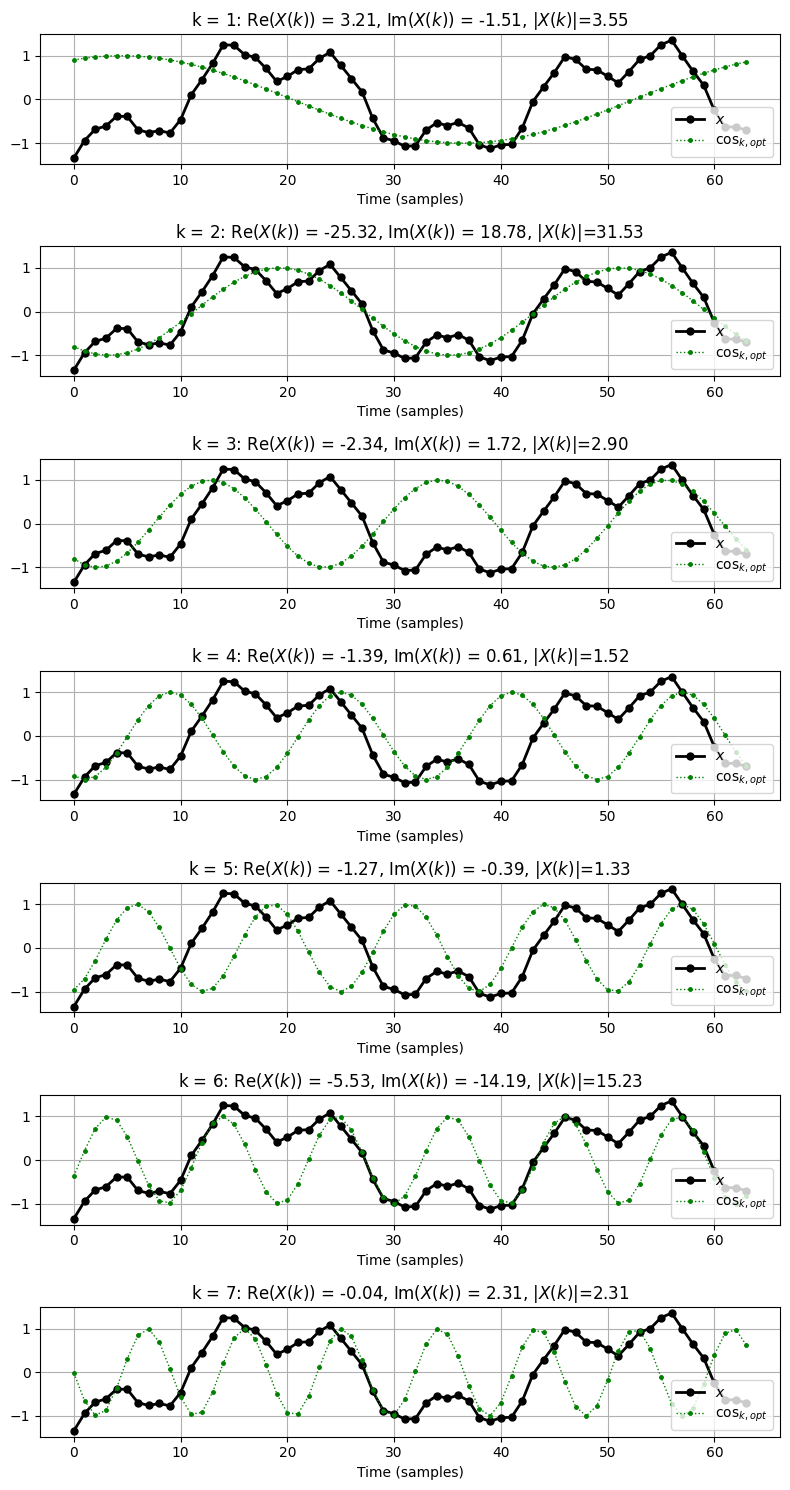

In [6]:
plt.figure(figsize=(8, 15))
for k in range(1, 8):
    ax = plt.subplot(7, 1, k)
    plot_signal_e_k(ax, x, k=k, show_e=False, show_opt=True)

plt.tight_layout()

<a id='dftmatrix'></a>
## DFT Matrix

Being a linear operator $\mathbb{C}^N \to \mathbb{C}^N$, the DFT can be expressed by some $N\times N$-matrix. This leads to the famous DFT matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ matrix, which is given by

$$\mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N)~~~~~~\forall n=0,1,\cdots,N-1,~\text{and}~k=0,1,\cdots,N-1.$$

Let $\rho_{N}:=\exp(2 \pi i / N)$ be the primitive $N^\mathrm{th}$ [root of unity](PCP_07_exp.html#roots). Then $\sigma_N:= \overline{\rho_N} = \mathrm{exp}(-2 \pi i / N)$ also defines a primitive $N^\mathrm{th}$ [root of unity](PCP_07_exp.html#roots). Then we can obtain that

$$ \sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn} = \mathrm{exp}(-2 \pi i k n / N)$$

From this, one obtains:

$$
\mathrm{DFT}_N =
\begin{pmatrix}
    1 & 1 & 1 & \dots  & 1 \\
    1 & \sigma_N & \sigma_N^2 & \dots  & \sigma_N^{N-1} \\
    1 & \sigma_N^2 & \sigma_N^4 & \dots  & \sigma_N^{2(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \sigma_N^{N-1} & \sigma_N^{2(N-1)} & \dots  & \sigma_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$

Note that the $k^\mathrm{th}$ row of $\mathrm{DFT}_N$ corresponds to the vector $\mathbf{e}_k \in \mathbb{C}^N$ as defined above. <br>
In the following visualization, the real and imaginary part of $\mathrm{DFT}_N$ are shown, where the values are encoded by suitable colors.

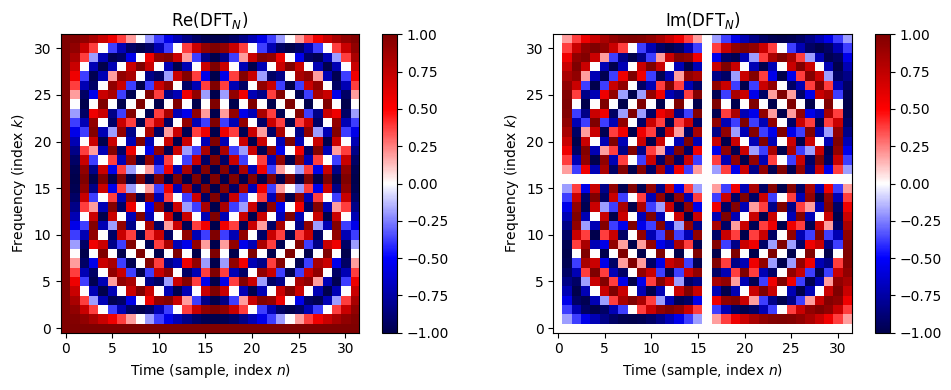

In [22]:
def generate_matrix_dft(K, N):
    """Generate a DFT (discete Fourier transfrom) matrix

    Notebook: PCP_09_dft.ipynb

    Args:
        K: Number of frequency bins
        N: Number of samples

    Returns:
        dft: The DFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    time_index = np.arange(N)
    for k in range(K):
        dft[k, :] = np.exp(-2j * np.pi * k * time_index / N)
    return dft

N = 32
dft_matrix = generate_matrix_dft(N, N)

plt.figure(figsize=(10, 4))
for i, (part, func) in enumerate({"Re": np.real, "Im": np.imag}.items(), start=1):
    plt.subplot(1, 2, i)
    plt.title(r'$\mathrm{{{part}}}(\mathrm{{DFT}}_N)$'.format(part=part))
    plt.imshow(func(dft_matrix), origin='lower', cmap='seismic', aspect='equal')
    plt.xlabel('Time (sample, index $n$)')
    plt.ylabel('Frequency (index $k$)')
    plt.colorbar()
    plt.tight_layout()

Now we can apply the matrix $DFT_{N}$ to a given signal $x\in\mathbb{C}^N$ to obtain its discrete fourier transform:

$$
X_{N \times 1} := 
\begin{pmatrix}
    x_0 \\
    x_1 \\
    \vdots \\ 
    x_{N-1}
\end{pmatrix}_{N \times 1}
=
\begin{pmatrix}
    e_0 \\
    e_1 \\
    \vdots \\ 
    e_{N-1}
\end{pmatrix}_{N \times N}
\cdot x
=
DFT_{N} \cdot x
$$

The peaks of the magnitude Fourier transform $|X|$ correspond to the main frequency components the signal is composed of. <br>
One can think $X$ as a collection of similarities between $x$ and various $e_k~\forall~k$. <br>
Note that the magnitude Fourier transform is symmetrical around the center. Why? For the interpretation of the time and frequency axis, see also <a href='#exercise_freq_index'>Exercise 1: Interpretation of Frequency Indices</a></li>

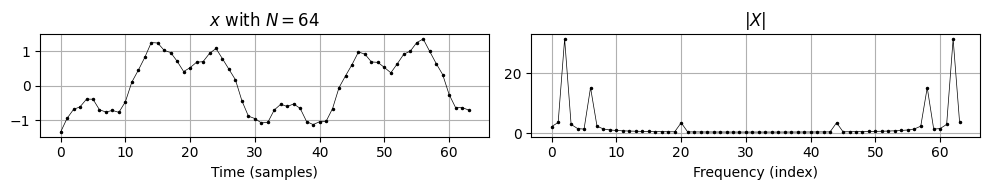

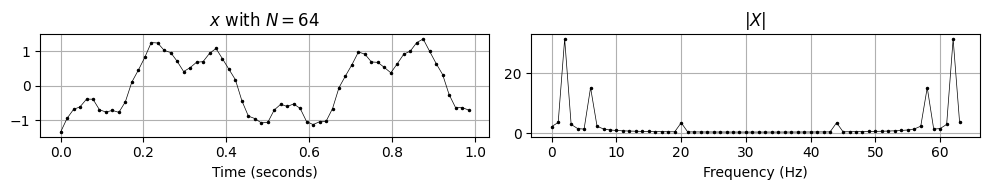

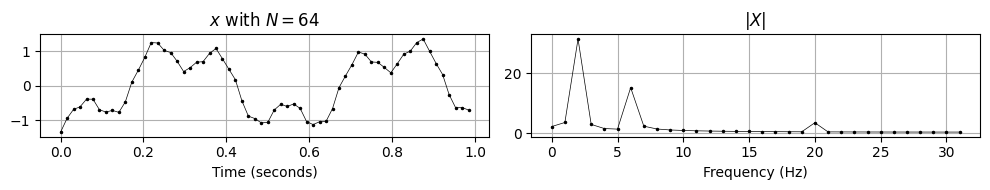

In [34]:
def dft(x):
    """Compute the discete Fourier transfrom (DFT)

    Notebook: PCP_09_dft.ipynb

    Args:
        x: Signal of shape N x 1 to be transformed

    Returns:
        X: Fourier transform of x with shape N x 1
    """
    x = x.astype(np.complex128)
    N = len(x)
    dft_mat = generate_matrix_dft(N, N)
    return np.dot(dft_mat, x)

def plot_signal_dft(t, x, X, ax_sec=False, ax_Hz=False, freq_half=False, figsize=(10, 2)):
    """Plotting function for signals and its magnitude DFT

    Notebook: PCP_09_dft.ipynb

    Args:
        t: Time axis (given in seconds) of length N
        x: Signal of same length as `t`.
        X: DFT of shape `len(x) x len(x)`.
        ax_sec: Plots time axis in seconds (Default value = False)
        ax_Hz: Plots frequency axis in Hertz (Default value = False)
        freq_half: Plots only low half of frequency coefficients (Default value = False)
        figsize: Size of figure (Default value = (10, 2))
    """
    N = len(x)
    K = N
    if freq_half is True:
        K = N // 2
        X = X[:K]

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.set_title('$x$ with $N=%d$' % N)
    if ax_sec is True:
        x_axis = t
        ax.set_xlabel('Time (seconds)')
    else:
        x_axis = range(len(x))
        ax.set_xlabel('Time (samples)')
    ax.plot(x_axis, x, 'k', marker='.', markersize='3', linewidth=0.5)
    ax.grid()

    ax = plt.subplot(1, 2, 2)
    ax.set_title('$|X|$')
    if ax_Hz is True:
        Fs = 1 / (t[1] - t[0])
        x_axis = Fs * np.arange(K) / N
        ax.set_xlabel('Frequency (Hz)')
    else:
        x_axis = range(len(X))
        ax.set_xlabel('Frequency (index)')
    ax.plot(np.abs(X), 'k', marker='.', markersize='3', linewidth=0.5)
    ax.grid()
    plt.tight_layout()
    plt.show()

N = 64
x, t = signal.generate_example_signal(Fs=N, dur=1)
X = dft(x)

plot_signal_dft(t, x, X)
plot_signal_dft(t, x, X, ax_sec=True, ax_Hz=True)
plot_signal_dft(t, x, X, ax_sec=True, ax_Hz=True, freq_half=True)

<a id='fft'></a>
## Fast Fourier Transform (FFT)

Next, we discuss the famous fast Fourier transform (FFT), which is a fast algorithm to compute the DFT. The FFT algorithm was originally found by Gauss in about 1805 and  then rediscovered by Cooley and Tukey in 1965. The FFT algorithm is based on the observation that applying a DFT of even size $N=2M$ can be expressed in terms of  applying two DFTs of half the size $M$. It exploits the fact that there are algebraic relations between the entries $\sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn}$ of DFT matrices. In particular, one has 

$$\sigma_{M}^{kn} = (\sigma_{N}^{kn})^2$$

In the FFT algorithm, one computes the DFT of the even-indexed and the uneven-indexed entries of $x$:

\begin{align}
(A(0), \dots, A(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(0), x(2), x(4), \dots, x(N-2))\\
(B(0), \dots, B(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(1), x(3), x(5), \dots, x(N-1))
\end{align}

With these two DFTs of size $N/2$, one can compute the full DFT of size $N$ via:

\begin{align}
C(k) &=& \sigma_N^k \cdot B(k)\\
X(k) &=& A(k) + C(k)\\
X(\frac{N}{2} + k) &=& A(k) - C(k) &,~~\forall k=0,\cdots,\frac{N}{2}-1\\
\end{align}

The numbers $\sigma_N^k$ are also called *twiddle factors*. If $N$ is a power of two, this idea can be applied recursively until one reaches the computation of $\mathrm{DFT}_{1}$ (the case $N=1$), which is simply multiplication by one (i.e. just returning the signal of length $N=1$). For further details, we refer to Section 2.4.3 of <a href="http://www.music-processing.de">[Müller, FMP, Springer 2015])</a> (see also Table 2.1). 

In the following code, we provide a function `fft` that implements the FFT algorithm. We test the function  `fft` by comparing its output with the one when applying the `dft` on a test signal `x`. For the comparison of result matrices, we use the NumPy functions [`np.array_equal`](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html) and [`np.allclose`](https://numpy.org/doc/stable/reference/generated/numpy.allclose.html#numpy.allclose).

In [54]:
def fft(x):
    """Compute the fast Fourier transform (FFT) recursively.

    Notebook: PCP_09_dft.ipynb

    Args:
        x: Signal to be transformed

    Returns:
        X: Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    assert np.log2(N) == int(np.log2(N)), 'N must be a power of two!'
    X = np.zeros(N, dtype=np.complex128)

    if N == 1:
        return x
    else:
        this_range = np.arange(N)
        A = fft(x[this_range % 2 == 0])
        B = fft(x[this_range % 2 == 1])
        range_twiddle_k = np.arange(N // 2)
        sigma = np.exp(-2j * np.pi * range_twiddle_k / N)
        C = sigma * B
        X[:N//2] = A + C
        X[N//2:] = A - C
        return X
    
N = 64
x, t = signal.generate_example_signal(Fs=N, dur=1)

X_via_dft = dft(x)
X_via_fft = fft(x)
X_via_fft_numpy = np.fft.fft(x)

is_equal = np.array_equal(X_via_dft, X_via_fft)
is_equal_tol = np.allclose(X_via_dft, X_via_fft)
is_equal_tol_np = np.allclose(X_via_dft, X_via_fft_numpy)

print('Equality test for dft(x) and fft(x) using np.array_equal:    ', is_equal)
print('Equality test for dft(x) and fft(x) using np.allclose:       ', is_equal_tol)
print('Equality test for dft(x) and np.fft.fft(x) using np.allclose:', is_equal_tol_np)

Equality test for dft(x) and fft(x) using np.array_equal:     False
Equality test for dft(x) and fft(x) using np.allclose:        True
Equality test for dft(x) and np.fft.fft(x) using np.allclose: True


<div class="alert alert-block alert-warning">
<strong>Note:</strong> The test shows that our <code>dft</code> and <code>fft</code> implementations do not yield the same result (due to numerical issues). However, the results are numerically very close, which is verified by the test using <code>np.allclose</code>.  
</div>

The FFT reduces the overall number of operations from the order of $N^2$ (needed when computing the usual matrix&ndash;vector product $\mathrm{DFT}_N \cdot x$) to the order of $N\log_2N$. The savings are enormous. For example, using $N=2^{10}=1024$, the FFT requires roughly $N\log_2N=10240$ instead of $N^2=1048576$ operations in the naive approach. Using the module `timeit`, which provides a simple way to time small bits of Python code, the following code compares the running time when using the naive approach and the FFT. Furthermore, we compare the running time with the highly optimized NumPy implementation <code>np.fft.fft</code>.

In [37]:
import timeit

rep = 3
for N in [256, 512, 1024, 2048, 4096]:
    time_index = np.arange(N)
    x = np.sin(2 * np.pi *  time_index / N )
    t_DFT = 1000 * timeit.timeit(lambda: dft(x), number=rep)/rep
    t_FFT = timeit.timeit(lambda: fft(x), number=rep*5)/(rep*5)
    t_FFT_np = timeit.timeit(lambda: np.fft.fft(x), number=rep*100)/(rep*100)
    print(f'Runtime (ms) for N = {N:4d} : DFT {t_DFT:10.2f},  FFT {t_FFT:.5f},  FFT_np {t_FFT_np:.8f}')

Runtime (ms) for N =  256 : DFT       3.89,  FFT 0.00292,  FFT_np 0.00000333
Runtime (ms) for N =  512 : DFT      12.04,  FFT 0.00584,  FFT_np 0.00000440
Runtime (ms) for N = 1024 : DFT      47.19,  FFT 0.01162,  FFT_np 0.00000721
Runtime (ms) for N = 2048 : DFT     174.00,  FFT 0.02309,  FFT_np 0.00001566
Runtime (ms) for N = 4096 : DFT     690.02,  FFT 0.04761,  FFT_np 0.00002668


## Exercises and Results

<a id='exercise_freq_index'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 1: Interpretation of Frequency Indices</strong><br>

Given a dimension $N\in\mathbb{N}$, the $\mathrm{DFT}_N$ transform a vector $x\in\mathbb{C}^N$ into another vector $X\in\mathbb{C}^N$. Assuming that $x$ represents a time-domain signal sampled with a sampling rate $F_\mathrm{s}$, one can associate the index $n\in[0:N-1]$ of the sample $x(n)$ with the physical time point $t = n/F_\mathrm{s}$ given in seconds. In case of the vector $X$, the index $k\in[0:N-1]$ of the coefficient $X(k)$ can be associated to a physical frequency value 

$$
  \omega=\frac{k \cdot F_\mathrm{s}}{N}.
$$
    
Furthermore, using a real-valued signal $x\in\mathbb{R}^N$, the upper part of $X\in\mathbb{C}^N$ becomes redundant, and it suffices to consider the first $K$ coefficients with $K=N/2$.
    
<ul>
<li>Find explanations why these properties apply.</li>
<li>Find out how the function <code>plot_signal_dft</code> uses these properties to convert and visualize the time and frequency axes.</li>   
<li>Using the signal <code>x, t = libpcp.signal.generate_example_signal(Fs=64, dur=2)</code>, plot the signal and its magnitude Fourier transform once using axes given in indices and once using axes given in physical units (seconds, Hertz). Discuss the results.</li>
<li>Do the same for the signal <code>x, t = libpcp.signal.generate_example_signal(Fs=32, dur=2)</code>. What is going wrong and why?</li>  
</ul>
</div>

In [ ]:
#<solution>
# Your Solution
#</solution>

<a id='exercise_missing_time'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 2: Missing Time Localization</strong><br>

The Fourier transform yields frequency information that is averaged over the entire time axis. However, the information on when these frequencies occur is hidden in the transform. To demonstrate this phenomenon, construct the following two different signals defined on a common time axis $[0, T]$ with $T$ given in seconds (e.g., $T=6~\mathrm{sec}$). 

- A superposition of two sinusoids $f_1+f_2$ defined over the entire time interval $[0, T]$, where the first sinusoid $f_1$ has a frequency $\omega_1=1~\mathrm{Hz}$ and an amplitude of $1$, while the second sinusoid $f_2$ has a frequency $\omega_2=5~\mathrm{Hz}$ and an amplitude of $0.5$.
- A concatenation of two sinusoids, where $f_1$ (specified as before) is now defined only on the subinterval $[0, T/2]$, and $f_2$ is defined on the subinterval $[T/2, T]$.
    
Sample the interval $[0,T]$ to obtain $N$ samples (use <code>np.linspace</code>), with $N\in\mathbb{N}$ being power of two (e.g., $N=256$). Define DT-signals of the superposition and the concatenation and compute the DFT for each of the signals. Plot the signals as well as the resulting magnitude Fourier transforms and discuss the result.
</div>

In [ ]:
#<solution>
# Your Solution
#</solution>

<a id='exercise_chirp'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 3: Chirp Signal</strong><br>

The function $f(t)=\sin\left(\pi t^2\right)$ defines a <strong>chirp signal</strong> (also called <strong>sweep signal</strong>), in which the frequency increases with time. The <strong>instantaneous frequency</strong> $\omega_t$ of the chirp signal at time $t$ is the derivate of the sinusoid's argument divided by $2\pi$, thus $\omega_t = t$. 

- Let $[t_0,t_1]$ be a time interval (given in seconds) with $0\leq t_0<t_1$ and $N\in\mathbb{N}$ be power of two. Implement a function <code>generate_chirp</code> that outputs a sampled chirp signal <code>x</code> over the interval $[t_0,t_1]$ with $N$ samples (use <code>np.linspace</code>).
- Compute the DFT of <code>x</code> for various input parameters $t_0$, $t_1$, and $N$. Plot the chirp signal as well as the resulting magnitude Fourier transform. Discuss the result.

In [ ]:
#<solution>
# Your Solution
#</solution>

<a id='exercise_inverse'></a>
<div class="alert alert-block alert-info">
<strong>Exercise 4: Inverse DFT</strong><br>

The discrete Fourier transform given by the matrix $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ is an invertible operation, given by the inverse DFT matrix $\mathrm{DFT}_N^{-1}$. 

- There is an explicit relation between $\mathrm{DFT}_N$ and its inverse $\mathrm{DFT}_N^{-1}$. Which one?
- Write a function <code>generate_matrix_dft_inv</code> that explicitly generates $\mathrm{DFT}_N^{-1}$. 
- Check your function by computing $\mathrm{DFT}_N \cdot \mathrm{DFT}_N^{-1}$ and $\mathrm{DFT}_N^{-1} \cdot \mathrm{DFT}_N$ (using <code>np.matmul</code>) and comparing these products with the identity matrix (using <code>np.eye</code> and <code>np.allclose</code>).
- Furthermore, compute the inverse DFT by using <code>np.linalg.inv</code>. Compare the result with your function using <code>np.allclose</code>.
- Similar to <code>fft</code>, implement a fast inverse Fourier transform <code>fft_inv</code>

In [ ]:
#<solution>
# Your Solution
#</solution>